# Preprocessing - Polygenic Risk Scores

In [82]:
%load_ext autoreload
%autoreload 2

import os
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import lifelines

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import neptune
import warnings
warnings.filterwarnings("ignore")
import shutil
import pathlib

dataset_name = "210212_cvd_gp"
path = "/data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb"
data_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS/data"
dataset_path = f"{data_path}/2_datasets_pre/{dataset_name}"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
data = pd.read_feather(f"{dataset_path}/baseline_covariates.feather")
data.head()

,eid,age_at_recruitment,sex,ethnic_background,townsend_deprivation_index_at_recruitment,date_of_attending_assessment_centre,uk_biobank_assessment_centre,birth_date,overall_health_rating,smoking_status,...,general_nutrients,all_other_non-therapeutic_products,contrast_media,diagnostic_radiopharmaceuticals,therapeutic_radiopharmaceuticals,surgical_dressings,statins,ass,atypical_antipsychotics,glucocorticoids
0,1000018,49.0,Female,White,-1.852930,2009-11-12,Sheffield,1960-11-12,Fair,Current,...,False,False,False,False,False,False,False,False,False,False
1,1000020,59.0,Male,White,0.204248,2008-02-19,Sheffield,1949-02-19,Good,Current,...,False,False,False,False,False,False,False,False,False,False
2,1000037,59.0,Female,White,-3.498860,2008-11-11,Sheffield,1949-11-11,Good,Previous,...,False,False,False,False,False,False,False,False,False,False
3,1000043,63.0,Male,White,-5.351150,2009-06-03,Sheffield,1946-06-03,Fair,Previous,...,False,False,False,False,False,False,False,False,False,False
4,1000051,51.0,Female,White,-1.799080,2006-06-10,Sheffield,1955-06-10,Poor,Never,...,False,False,False,False,False,False,True,False,True,False


In [603]:
data_fp = f"/data/analysis/ag-reils/steinfej/data/3_datasets_post/210212_cvd_gp/partition_0/train/data_imputed_normalized.feather"
data = pd.read_feather(data_fp)#.dropna()
description = pd.read_feather(f"{pathlib.Path(data_fp).parents[2]}/description.feather")

In [640]:
mult = int(1/(len(data[data.MACE_event==True])/len(data)))
mult

14

In [638]:
len(data)

284931

,eid,age_at_recruitment,sex,ethnic_background,townsend_deprivation_index_at_recruitment,date_of_attending_assessment_centre,uk_biobank_assessment_centre,birth_date,overall_health_rating,smoking_status,...,overall_health_rating_3.0,smoking_status_0.0,smoking_status_1.0,smoking_status_2.0,alcohol_intake_frequency_0.0,alcohol_intake_frequency_1.0,alcohol_intake_frequency_2.0,alcohol_intake_frequency_3.0,alcohol_intake_frequency_4.0,alcohol_intake_frequency_5.0
0,1000018,-0.786545,0.0,0.0,-0.163263,2009-11-12,0.0,1960-11-12,0.0,0.0,...,0,1,0,0,1,0,0,0,0,0
1,1000020,0.448044,1.0,0.0,0.509207,2008-02-19,0.0,1949-02-19,1.0,0.0,...,0,1,0,0,1,0,0,0,0,0
2,1000043,0.941880,1.0,0.0,-1.306795,2009-06-03,0.0,1946-06-03,0.0,1.0,...,0,0,1,0,0,1,0,0,0,0
3,1000079,0.571503,0.0,0.0,-0.442790,2008-03-18,0.0,1948-03-18,0.0,2.0,...,0,0,0,1,1,0,0,0,0,0
4,1000084,-1.527299,1.0,0.0,2.915721,2007-10-18,0.0,1964-10-18,0.0,2.0,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284805,5521055,0.818421,0.0,0.0,-0.559274,2009-11-24,17.0,1947-11-24,1.0,2.0,...,0,0,0,1,1,0,0,0,0,0
284815,5521173,0.448044,1.0,0.0,-0.833230,2008-02-28,17.0,1949-02-28,1.0,2.0,...,0,0,0,1,0,1,0,0,0,0
284832,5521549,-1.774217,1.0,0.0,-1.235223,2009-01-19,17.0,1968-01-19,1.0,2.0,...,0,0,0,1,1,0,0,0,0,0
284854,5521845,0.077668,0.0,0.0,-0.847005,2007-10-30,17.0,1951-10-30,1.0,2.0,...,0,0,0,1,1,0,0,0,0,0


In [621]:

    basics = [
        'age_at_recruitment',
        'ethnic_background_0.0',
        'ethnic_background_1.0',
        'ethnic_background_5.0',#na 2 -> 5
        'ethnic_background_3.0',
        'ethnic_background_4.0',
        'townsend_deprivation_index_at_recruitment',
        'sex'
    ]
    questionnaire = [
        'overall_health_rating_0.0',
        'overall_health_rating_1.0',
        'overall_health_rating_2.0',
        'overall_health_rating_3.0',
        'smoking_status_0.0',
        'smoking_status_1.0',
        'smoking_status_2.0',
    ]
measurements = [
    'body_mass_index_bmi',
    'weight',
    "standing_height",
    'systolic_blood_pressure',
    'diastolic_blood_pressure',
]

labs = [
    "cholesterol",
    "hdl_cholesterol",
    "ldl_direct",
    "triglycerides"
]

family_history = [
    'fh_heart_disease',
]

diagnoses = [
    'diabetes1',
    'diabetes2',
    'chronic_kidney_disease',
    'atrial_fibrillation',
    'migraine',
    'rheumatoid_arthritis',
    'systemic_lupus_erythematosus',
    'severe_mental_illness',
    'erectile_dysfunction',
]

medications = [
    "statins",
    "antihypertensives",
    "ass",
    "atypical_antipsychotics",
    "glucocorticoids"
]

pgs = [
    'PGS000011',
    'PGS000057',
    'PGS000058',
    'PGS000059']

feature_dict = {
    "pgs": pgs,
    "basics": basics,
    "questionnaire": questionnaire,
    "measurements": measurements,
    "labs": labs,
    "family_history": family_history,
    "medications": medications,
    "diagnoses": diagnoses
}

features = [f for group_list in feature_dict.values() for f in group_list]
target = "MACE_event"

In [613]:
!pip install imbalanced_databases

     |████████████████████████████████| 4.3 MB 4.6 MB/s eta 0:00:01


In [624]:
import imbalanced_databases as imbd
dataset= imbd.load_iris0()
dataset["data"].shape

(150, 4)

In [604]:
import smote_variants as sv

oversampler= sv.polynom_fit_SMOTE()

In [629]:
smote_df = data.sample(10000)
for c in smote_df.columns:
    if smote_df[c].dtype=="bool":
        #print(smote_df[c].dtype)
        smote_df[c] = smote_df[c].astype(float)
X_samp, y_samp = oversampler.sample(smote_df[features].values, smote_df[target].values)

2021-02-16 22:54:55,131:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': None}")


In [631]:
X_samp

array([[ 1.78882453,  0.77797397,  0.12463653, ...,  0.        ,
         0.        ,  0.        ],
       [-0.77867311, -1.34328462, -0.38160009, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.2802518 , -0.21876199, -0.43298506, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.04400338,  0.01484893,  0.49036118, ...,  0.00221043,
         0.10831123,  0.03868258],
       [ 0.0634923 ,  0.03054282,  0.35859966, ...,  0.00243148,
         0.11914235,  0.04255084],
       [ 0.08298123,  0.04623672,  0.22683815, ...,  0.00265252,
         0.12997347,  0.0464191 ]])

In [572]:
description.set_index("covariate")[-50:-30]

,index,id,dtype,isTarget,based_on,aggr_fn,mapping
covariate,,,,,,,
death_cvd_comp_event,73.0,74.0,int,True,endpoints_competing,NaN,None
death_cvd_comp_event_time,74.0,75.0,float,True,endpoints_competing,NaN,None
SCORE_comp_event,75.0,76.0,int,True,endpoints_competing,NaN,None
SCORE_comp_event_time,76.0,77.0,float,True,endpoints_competing,NaN,None
ASCVD_comp_event,77.0,78.0,int,True,endpoints_competing,NaN,None
ASCVD_comp_event_time,78.0,79.0,float,True,endpoints_competing,NaN,None
QRISK3_comp_event,79.0,80.0,int,True,endpoints_competing,NaN,None
QRISK3_comp_event_time,80.0,81.0,float,True,endpoints_competing,NaN,None
MACE_comp_event,81.0,82.0,int,True,endpoints_competing,NaN,None


In [557]:
#from sklearn.preprocessing import OrdinalEncoder
from category_encoders.ordinal import OrdinalEncoder
cat_cols = [c for c in description.set_index("dtype").loc[["category"]].covariate.to_list() if "date" not in c]

In [587]:
mapping = [{"col": c, "mapping": {e: i for i, e in enumerate([v for v in data[c].unique().tolist() if v==v])}} for c in cat_cols]
for i, c in enumerate(cat_cols): mapping[i]["mapping"].update({np.nan: -2})

In [586]:
[v for v in data[c].unique().tolist() if v is not np.nan][6]==pd.nan

AttributeError: module 'pandas' has no attribute 'nan'

In [588]:
mapping

[{'col': 'sex', 'mapping': {0.0: 0, 1.0: 1, nan: -2}},
 {'col': 'ethnic_background',
  'mapping': {0.0: 0, 1.0: 1, 3.0: 2, 4.0: 3, 5.0: 4, nan: -2}},
 {'col': 'uk_biobank_assessment_centre',
  'mapping': {0.0: 0,
   1.0: 1,
   2.0: 2,
   3.0: 3,
   4.0: 4,
   5.0: 5,
   6.0: 6,
   7.0: 7,
   8.0: 8,
   9.0: 9,
   10.0: 10,
   11.0: 11,
   12.0: 12,
   13.0: 13,
   14.0: 14,
   15.0: 15,
   16.0: 16,
   17.0: 17,
   nan: -2}},
 {'col': 'overall_health_rating',
  'mapping': {0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3, nan: -2}},
 {'col': 'smoking_status', 'mapping': {0.0: 0, 1.0: 1, 2.0: 2, nan: -2}},
 {'col': 'alcohol_intake_frequency',
  'mapping': {0.0: 0, 1.0: 1, 3.0: 2, 4.0: 3, 5.0: 4, 2.0: 5, nan: -2}}]

In [558]:
from category_encoders.ordinal import OrdinalEncoder
cat_cols = [c for c in description.set_index("dtype").loc[["category"]].covariate.to_list() if "date" not in c]

mapping = [{"col": c, "mapping": {e:i for i, e in enumerate(data[c].unique().tolist())}} for c in cat_cols]
for i, c in enumerate(cat_cols): mapping[i]["mapping"].update({np.nan:-2})

enc = OrdinalEncoder(cols=cat_cols, mapping=mapping, handle_missing="return_nan")
data = enc.fit_transform(data)

description["mapping"] = np.nan
for i, c in enumerate(cat_cols):
    description.loc[description.covariate == c, 'mapping'] = str(enc.mapping[i]["mapping"])
    if data[c].nunique()>2: 
        ohe_encoded = pd.get_dummies(data[c], prefix=c)
        data[ohe_encoded.columns] = ohe_encoded
        for col in ohe_encoded.columns:
            description = description.append(
                {"covariate": col, "dtype": "bool", "isTarget": False, "based_on": description.loc[description.covariate == c, "based_on"].iloc[0], 
                 "aggr_fn": np.nan, "mapping":str(enc.mapping[i]["mapping"])}, ignore_index=True)

In [559]:
data

,eid,age_at_recruitment,sex,ethnic_background,townsend_deprivation_index_at_recruitment,date_of_attending_assessment_centre,uk_biobank_assessment_centre,birth_date,overall_health_rating,smoking_status,...,smoking_status_0.0,smoking_status_1.0,smoking_status_2.0,alcohol_intake_frequency_0.0,alcohol_intake_frequency_1.0,alcohol_intake_frequency_2.0,alcohol_intake_frequency_3.0,alcohol_intake_frequency_4.0,alcohol_intake_frequency_5.0,ethnic_background_2.0
0,1000018,49.0,0.0,0.0,-1.85293,2009-11-12,0.0,1960-11-12,0.0,0.0,...,1,0,0,1,0,0,0,0,0,0
1,1000037,59.0,0.0,0.0,-3.49886,2008-11-11,0.0,1949-11-11,1.0,1.0,...,0,1,0,1,0,0,0,0,0,0
2,1000043,63.0,1.0,0.0,-5.35115,2009-06-03,0.0,1946-06-03,0.0,1.0,...,0,1,0,0,1,0,0,0,0,0
3,1000084,43.0,1.0,0.0,7.56610,2007-10-18,0.0,1964-10-18,0.0,2.0,...,0,0,1,1,0,0,0,0,0,0
4,1000092,50.0,0.0,1.0,7.66418,2009-06-16,0.0,1959-06-16,2.0,0.0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28366,1450270,42.0,0.0,1.0,1.22516,2007-08-02,1.0,1965-08-02,1.0,2.0,...,0,0,1,0,0,0,0,0,1,0
28367,1450285,60.0,0.0,0.0,-3.28244,2008-01-19,1.0,1948-01-19,1.0,2.0,...,0,0,1,0,0,0,0,1,0,0
28368,1450301,67.0,1.0,0.0,-3.45544,2010-03-16,1.0,1943-03-16,1.0,1.0,...,0,1,0,0,0,0,0,0,1,0
28369,1450334,53.0,0.0,0.0,5.85141,2009-06-30,1.0,1956-06-30,1.0,1.0,...,0,1,0,0,0,1,0,0,0,0


In [560]:
description.set_index("covariate")[-30:-10]

,index,id,dtype,isTarget,based_on,aggr_fn,mapping
covariate,,,,,,,
copd_comp_event,71.0,72.0,int,True,endpoints_competing,NaN,NaN
copd_comp_event_time,72.0,73.0,float,True,endpoints_competing,NaN,NaN
death_cvd_comp_event,73.0,74.0,int,True,endpoints_competing,NaN,NaN
death_cvd_comp_event_time,74.0,75.0,float,True,endpoints_competing,NaN,NaN
SCORE_comp_event,75.0,76.0,int,True,endpoints_competing,NaN,NaN
SCORE_comp_event_time,76.0,77.0,float,True,endpoints_competing,NaN,NaN
ASCVD_comp_event,77.0,78.0,int,True,endpoints_competing,NaN,NaN
ASCVD_comp_event_time,78.0,79.0,float,True,endpoints_competing,NaN,NaN
QRISK3_comp_event,79.0,80.0,int,True,endpoints_competing,NaN,NaN


In [467]:
description

,index,id,dtype,isTarget,based_on,aggr_fn,mapping
covariate,,,,,,,
sex,2,3,category,False,basics,NaN,"{'Female': 0, 'Male': 1, nan: -2}"


In [448]:
description = description.set_index("covariate")

In [454]:
description

,index,id,dtype,isTarget,based_on,aggr_fn,mapping
covariate,,,,,,,
ethnic_background,3,4,category,False,basics,NaN,test


In [ ]:
enc.mapping

In [ ]:
data[data.columns[1:20]]

In [ ]:
enc.mapping[5]["mapping"].loc

In [ ]:
description[1:20]

In [220]:
enc.categories_

AttributeError: 'OrdinalEncoder' object has no attribute 'categories_'

In [187]:
from sklearn.preprocessing import OrdinalEncoder
    for c in cat_cols:
        enc = OrdinalEncoder()
        if data[c]==2: data[c] = enc.fit_transform(data[c])
        if data[c]>2: 
            ohe_encoded = pd.get_dummies(data[c], prefix=c)
            data[ohe_encoded.columns] = ohe_encoded
            for col in ohe_encoded.columns:
                description = description.append(
                    {"covariate": col, "dtype": "bool", "isTarget": False, "based_on": np.nan, "aggr_fn": np.nan},
                    ignore_index=True)

NameError: name 'OrdinalEncoder' is not defined

In [186]:
description \
        .set_index('dtype').loc[['int', "float"]] \
        .query("(isTarget == False) & (based_on != 'diagnoses_emb') & (based_on != 'eid')")['covariate'].values

array(['age_at_recruitment', 'townsend_deprivation_index_at_recruitment',
       'body_mass_index_bmi', 'weight',
       'pulse_wave_arterial_stiffness_index',
       'pulse_wave_reflection_index', 'waist_circumference',
       'hip_circumference', 'standing_height', 'trunk_fat_percentage',
       'body_fat_percentage', 'basal_metabolic_rate',
       'forced_vital_capacity_fvc_best_measure',
       'forced_expiratory_volume_in_1second_fev1_best_measure',
       'fev1_fvc_ratio_zscore', 'peak_expiratory_flow_pef_f3064_0_2',
       'peak_expiratory_flow_pef_f3064_0_1', 'peak_expiratory_flow_pef',
       'systolic_blood_pressure', 'diastolic_blood_pressure',
       'pulse_rate', 'basophill_count', 'basophill_percentage',
       'eosinophill_count', 'eosinophill_percentage',
       'haematocrit_percentage', 'haemoglobin_concentration',
       'high_light_scatter_reticulocyte_count',
       'high_light_scatter_reticulocyte_percentage',
       'immature_reticulocyte_fraction', 'lymphocyte_co

In [105]:
data.column

,level_0,index,id,covariate,dtype,isTarget,based_on,aggr_fn
0,0,0,1,eid,integer,False,eid,NaN
1,1,1,2,age_at_recruitment,numeric,False,basics,NaN
2,2,2,3,sex,category,False,basics,NaN
3,3,3,4,ethnic_background,category,False,basics,NaN
4,4,4,5,townsend_deprivation_index_at_recruitment,numeric,False,basics,NaN
...,...,...,...,...,...,...,...,...
2951,2951,78,79,ASCVD_comp_event_time,numeric,True,endpoints_competing,NaN
2952,2952,79,80,QRISK3_comp_event,integer,True,endpoints_competing,NaN
2953,2953,80,81,QRISK3_comp_event_time,numeric,True,endpoints_competing,NaN
2954,2954,81,82,MACE_comp_event,integer,True,endpoints_competing,NaN


In [139]:
description.query("covariate ==@features")[["covariate", "dtype"]]

,covariate,dtype
1,age_at_recruitment,numeric
17,standing_height,numeric
102,myocardial_infarction,logical


In [117]:
features = ["standing_height", "age_at_recruitment", "myocardial_infarction", "ethnicity"]

In [123]:
continuous = description.query("covariate ==@features").query("dtype in ['integer', 'numeric']").covariate.values

In [124]:
[data.columns.to_list().index(v) for v in continuous]

[1, 17]

In [127]:
data.iloc[:,1].nunique()

37

## Score Weights

PGS Catalogue searched for ["Atrial Fibrillation", "Coronary Artery Disease", "Coronary Heart Disease", "Stroke"] 

In [88]:
pgs_planned = sorted([p.absolute() for p in list(pathlib.Path(f"{data_path}/1_genetics/pgs_weights/raw").rglob('*.txt'))])
pgs_planned_list = [p.name[:-4] for p in pgs_planned]
pgs_planned_dict = dict(zip(pgs_planned_list, pgs_planned))

In [89]:
pgs_planned_dict

{'PGS000010': PosixPath('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/1_genetics/pgs_weights/raw/PGS000010.txt'),
 'PGS000011': PosixPath('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/1_genetics/pgs_weights/raw/PGS000011.txt'),
 'PGS000012': PosixPath('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/1_genetics/pgs_weights/raw/PGS000012.txt'),
 'PGS000013': PosixPath('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/1_genetics/pgs_weights/raw/PGS000013.txt'),
 'PGS000016': PosixPath('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/1_genetics/pgs_weights/raw/PGS000016.txt'),
 'PGS000018': PosixPath('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/1_genetics/pgs_weights/raw/PGS000018.txt'),
 'PGS000019': PosixPath('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/1_genetics/pgs_weights/raw/PGS000019.txt'),
 'PGS000035': PosixPath('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/1_genetics/pgs_weights/raw/PGS000035.txt'),
 'PGS000038': Po

## Get Scores

In [90]:
pgs_finished = sorted([p.parent.absolute() for p in list(pathlib.Path(f"{data_path}/1_genetics").rglob('*distribution_plot.png'))])
pgs_list = [p.name for p in pgs_finished]
pgs_dict = dict(zip(pgs_list, pgs_finished))

In [91]:
pgs_dict

{'PGS000011': PosixPath('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/1_genetics/pgs_calculated/PGS000011'),
 'PGS000013': PosixPath('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/1_genetics/pgs_calculated/PGS000013'),
 'PGS000016': PosixPath('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/1_genetics/pgs_calculated/PGS000016'),
 'PGS000018': PosixPath('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/1_genetics/pgs_calculated/PGS000018'),
 'PGS000039': PosixPath('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/1_genetics/pgs_calculated/PGS000039'),
 'PGS000057': PosixPath('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/1_genetics/pgs_calculated/PGS000057'),
 'PGS000058': PosixPath('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/1_genetics/pgs_calculated/PGS000058'),
 'PGS000059': PosixPath('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/1_genetics/pgs_calculated/PGS000059'),
 'PGS000116': PosixPath('/data/analysis/ag-reils/ag-reil

In [92]:
len(pgs_dict)

12

In [93]:
list(pgs_dict.keys())

['PGS000011',
 'PGS000013',
 'PGS000016',
 'PGS000018',
 'PGS000039',
 'PGS000057',
 'PGS000058',
 'PGS000059',
 'PGS000116',
 'PGS000117',
 'PGS000192',
 'PGS000296']

In [94]:
# PGS00039: Cardiovascular Disease
# PGS000117: Stroke

In [95]:
data_pgs = data[["eid"]]
for pgs, pgs_path in pgs_dict.items():
    temp = pd.read_csv(str(pgs_path)+"/PRSice.all_score", delim_whitespace=True)
    temp = temp[temp.columns[-2:]]
    temp.columns = ["eid", pgs]
    data_pgs = data_pgs.merge(temp, on="eid", how="left")

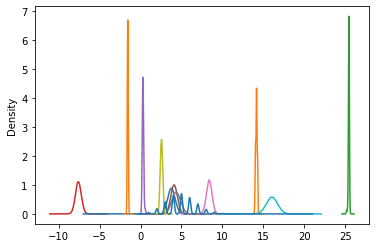

In [12]:
for pgs in pgs_dict.keys():
    data_pgs[pgs].plot.kde()

## Plotting

In [13]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn_pandas import DataFrameMapper
        
leave_eid = [(col, None) for col in ["eid"]]
standardize = [([col], StandardScaler()) for col in list(pgs_dict.keys())]

mapper = DataFrameMapper(leave_eid + standardize, df_out=True)
data_pgs_tf = mapper.fit_transform(data_pgs)

ModuleNotFoundError: No module named 'sklearn_pandas'

In [97]:
data_pgs

,eid,PGS000011,PGS000013,PGS000016,PGS000018,PGS000039,PGS000057,PGS000058,PGS000059,PGS000116,PGS000117,PGS000192,PGS000296
0,1000018,3.170770,14.182161,25.478597,-7.910004,0.196099,3.690275,8.513230,4.060235,2.543097,15.850781,3.0,-1.531660
1,1000020,3.935565,14.203609,25.508855,-7.338207,0.382054,4.170000,8.665529,3.640000,2.575014,16.197177,4.0,-1.529472
2,1000037,4.223654,14.248176,25.549722,-7.533061,0.189988,4.288627,8.540908,5.541451,2.441255,16.068202,7.0,-1.549326
3,1000043,3.529575,14.176502,25.394145,-7.768648,0.289388,4.130000,8.515447,4.261098,2.740589,16.860180,9.0,-1.565533
4,1000051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
502499,6025150,4.181800,14.053589,25.402026,-7.499164,0.272956,4.470000,8.425411,4.660235,2.419166,16.650813,3.0,-1.504692
502500,6025165,4.315743,14.131477,25.417482,-7.736421,0.275103,3.900941,8.046961,4.000196,2.721753,16.601598,2.0,-1.582081
502501,6025173,3.096671,14.186225,25.488755,-8.079815,0.352918,3.507804,7.994697,3.690706,2.687853,17.412722,5.0,-1.682143
502502,6025182,3.699646,14.134693,25.439013,-7.962928,0.343860,4.020000,8.151277,3.960000,2.692526,16.256542,4.0,-1.611761


In [ ]:
for pgs in pgs_dict.keys():
    data_pgs_tf[pgs].plot.kde()

In [ ]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
 
# Basic correlogram
g = sns.pairplot(data_pgs_tf[list(pgs_dict.keys())])
g.map_lower(corrfunc)
plt.show()

## Write to disk

In [149]:
dtypes = {"int32":"int", "int64":"int", "float64":"float", "category":"category", "object":"category", "bool":"bool"}
desc_dict = {"id": [*range(1, len(data_pgs.columns.to_list())+1)] , 
             "covariate": data_pgs.columns.to_list(), 
             "dtype":[dtypes[str(col)] for col in data_pgs.dtypes.to_list()], 
             "isTarget":[False for col in data_pgs.columns.to_list()],
            "based_on":["PGS" if col!="eid" else "eid" for col in data_pgs.columns.to_list()],
            "aggr_fn": [np.nan for col in data_pgs.columns.to_list()]}
data_pgs_description = pd.DataFrame.from_dict(desc_dict)
data_pgs_description

,id,covariate,dtype,isTarget,based_on,aggr_fn
0,1,eid,int,False,eid,NaN
1,2,PGS000011,float,False,PGS,NaN
2,3,PGS000013,float,False,PGS,NaN
3,4,PGS000016,float,False,PGS,NaN
4,5,PGS000018,float,False,PGS,NaN
5,6,PGS000039,float,False,PGS,NaN
6,7,PGS000057,float,False,PGS,NaN
7,8,PGS000058,float,False,PGS,NaN
8,9,PGS000059,float,False,PGS,NaN
9,10,PGS000116,float,False,PGS,NaN


In [150]:
data_pgs.to_feather(f"{dataset_path}/baseline_pgs.feather")
data_pgs_description.to_feather(f"{dataset_path}/baseline_pgs_description.feather")